In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

2024-03-10 20:49:26.075327: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-10 20:49:26.117364: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 20:49:26.117397: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 20:49:26.117416: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-10 20:49:26.125118: I tensorflow/core/platform/cpu_feature_g

In [2]:
file_path = "myData2.parquet"
df = pd.read_parquet(file_path)

In [3]:
# selected_features = ['timestamp_seconds', 
#                      'node_memory_Percpu_bytes', 
#                      'node_context_switches_total', 
#                      'surfsara_power_usage', 
#                      'node_netstat_Tcp_InSegs', 
#                      'node_netstat_Tcp_OutSegs', 
#                      'node_network_transmit_packets_total-sum', 
#                      'node_filesystem_size_bytes-sum']


In [4]:
selected_features = ['timestamp_seconds', 
                     'node_memory_Percpu_bytes', 
                     'node_context_switches_total', 
                     'surfsara_power_usage', 
                     'node_netstat_Tcp_InSegs', 
                     'node_netstat_Tcp_OutSegs', 
                     'node_network_transmit_packets_total-sum', 
                     'node_filesystem_size_bytes-sum', 
                     'node_filesystem_files-sum', 
                     'node_memory_MemFree_bytes', 
                     'node_netstat_Tcp_InErrs']


In [5]:
# df_selected.head(20)
# df_selected['target'].value_counts()
# df.info(max_cols=100)
# data.head(20)
# df_selected

In [6]:
# Define time intervals
time_intervals = {'minute': '1T', 'hour': '1H', 'day': '1D'}

# Set sequence length
sequence_length = 30

# Number of time steps to predict into the future
prediction_steps = 7

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [7]:
# Function to create sequences for LSTM with aligned targets
def create_lstm_sequences(data, sequence_length, prediction_steps):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length - prediction_steps + 1):
        seq = data.iloc[i:i+sequence_length].values
        target = data.iloc[i+sequence_length:i+sequence_length+prediction_steps]['target'].values
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


In [8]:
# Function to make predictions on new data
def predict_future_failures(model, input_data, sequence_length, prediction_steps):
    predictions = []

    for _ in range(prediction_steps):
        # Make a prediction for the next time step
        prediction = model.predict(input_data.reshape(1, sequence_length, input_data.shape[1]))
        predictions.append(prediction[0, 0])

        # Shift the input data by one time step and append the new prediction
        input_data = np.roll(input_data, shift=-1, axis=0)
        # Update the last time step with the actual next target value
        input_data[-1, -1] = prediction[0, 0]  # or use actual next target value

    return predictions


In [9]:
# Function to prepare data for LSTM
def prepare_lstm_data(data, time_interval):
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
    data.set_index('timestamp', inplace=True)
    data_resampled = data.resample(time_interval).sum()
    # data_resampled['target'] = data_resampled['target'].clip(upper=1)  # Clip values to 1
    return data_resampled

# 30 days -> 7 days

In [10]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [11]:
# Prepare data for LSTM with daily intervals
lstm_data_day = prepare_lstm_data(df_selected, time_intervals['day'])

# Create sequences and targets
sequences_day, targets_day = create_lstm_sequences(lstm_data_day, sequence_length, prediction_steps)

# Flatten the target values to match the model's output shape
targets_day = targets_day.reshape(-1, 1)


In [12]:
# Define the index to split the data
split_index = int(len(sequences_day) * 0.7)  # Use 70% of the data for training

# Split the data into training and testing sets
X_train_day, X_test_day = sequences_day[:split_index], sequences_day[split_index:]
y_train_day, y_test_day = targets_day[:split_index], targets_day[split_index:]


In [13]:
y_test_day

array([[    0],
       [    0],
       [ 2308],
       [ 2880],
       [ 2880],
       [ 2880],
       [ 2640],
       [    0],
       [ 2308],
       [ 2880],
       [ 2880],
       [ 2880],
       [ 2640],
       [ 2004],
       [ 2308],
       [ 2880],
       [ 2880],
       [ 2880],
       [ 2640],
       [ 2004],
       [    0],
       [ 2880],
       [ 2880],
       [ 2880],
       [ 2640],
       [ 2004],
       [    0],
       [    0],
       [ 2880],
       [ 2880],
       [ 2640],
       [ 2004],
       [    0],
       [    0],
       [    0],
       [ 2880],
       [ 2640],
       [ 2004],
       [    0],
       [    0],
       [    0],
       [    0],
       [ 2640],
       [ 2004],
       [    0],
       [    0],
       [    0],
       [    0],
       [   24],
       [ 2004],
       [    0],
       [    0],
       [    0],
       [    0],
       [   24],
       [ 1378],
       [    0],
       [    0],
       [    0],
       [    0],
       [   24],
       [ 1378],
       [

In [14]:
# Build the LSTM model
lstm_model_day = Sequential()
lstm_model_day.add(LSTM(100, input_shape=(X_train_day.shape[1], X_train_day.shape[2]), return_sequences=True))
lstm_model_day.add(Dropout(0.2))
lstm_model_day.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=0.01)
lstm_model_day.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])

# Train the model
history_day = lstm_model_day.fit(X_train_day, y_train_day, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20


2/2 [==============================] - 3s 545ms/step - loss: 1596.4812 - mean_absolute_error: 1596.4812 - val_loss: 1823.7026 - val_mean_absolute_error: 1823.7026
Epoch 2/20
2/2 [==============================] - 0s 84ms/step - loss: 1595.6737 - mean_absolute_error: 1595.6737 - val_loss: 1823.2828 - val_mean_absolute_error: 1823.2828
Epoch 3/20
2/2 [==============================] - 0s 78ms/step - loss: 1594.9750 - mean_absolute_error: 1594.9750 - val_loss: 1822.9023 - val_mean_absolute_error: 1822.9023
Epoch 4/20
2/2 [==============================] - 0s 76ms/step - loss: 1594.5721 - mean_absolute_error: 1594.5721 - val_loss: 1822.4574 - val_mean_absolute_error: 1822.4574
Epoch 5/20
2/2 [==============================] - 0s 76ms/step - loss: 1594.1145 - mean_absolute_error: 1594.1145 - val_loss: 1822.1436 - val_mean_absolute_error: 1822.1436
Epoch 6/20
2/2 [==============================] - 0s 80ms/step - loss: 1593.6444 - mean_absolute_error: 1593.6444 - val_loss: 1821.7129 - val_mea

In [15]:
# y_test_day[0]

In [16]:
print("X_test_day shape:", X_test_day.shape)
print("y_test_day shape:", y_test_day.shape)


X_test_day shape: (24, 30, 12)
y_test_day shape: (504, 1)


In [17]:
from sklearn.metrics import mean_absolute_error

# Make predictions on the test data
y_pred_day = lstm_model_day.predict(X_test_day)

# Calculate Mean Absolute Error
mae_day = mean_absolute_error(y_test_day, y_pred_day)
print(f'Model Mean Absolute Error: {mae_day:.4f}\n')


1/1 [==============================] - 0s 416ms/step


ValueError: Found input variables with inconsistent numbers of samples: [504, 24]

In [ ]:
input_data = X_test_day[2]  # Can be any valid starting point

# Make predictions
predicted_failures = predict_future_failures(lstm_model_day, input_data, sequence_length, prediction_steps)

# Denormalize the predicted failures 
predicted_failures_denormalized = predicted_failures * (lstm_data_day['target'].max() - lstm_data_day['target'].min()) + lstm_data_day['target'].min()

# Print the predicted failures
print("Predicted failures for the next 7 days:")
print(predicted_failures_denormalized)

# # Evaluate the predictions using Mean Squared Error
# mse_predictions = np.mean((predicted_failures - y_test_day[3:3+prediction_steps])**2)
# print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures - y_test_day[3:3+prediction_steps]))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')


1/1 [==============================] - 0s 20ms/step
Predicted failures for the next 7 days:
[[18.497274]
 [18.497274]
 [18.497274]
 ...
 [18.497274]
 [18.773813]
 [18.773813]]
Mean Absolute Error for Predictions: 2339.2801


### Performance

#### Training and Validation Loss Plot

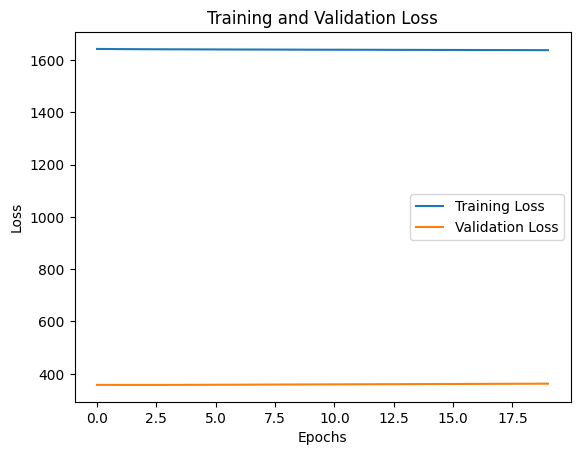

In [ ]:
# Plot training and validation loss
plt.plot(history_day.history['loss'], label='Training Loss')
plt.plot(history_day.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


#### Predicted Failures vs. True Failures Plot

In [ ]:
y_test_day[2]

2282.0

In [ ]:
predicted_failures_denormalized

array([[18.339506],
       [18.339506],
       [18.537231],
       ...,
       [18.537231],
       [18.537231],
       [18.537231]], dtype=float32)

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


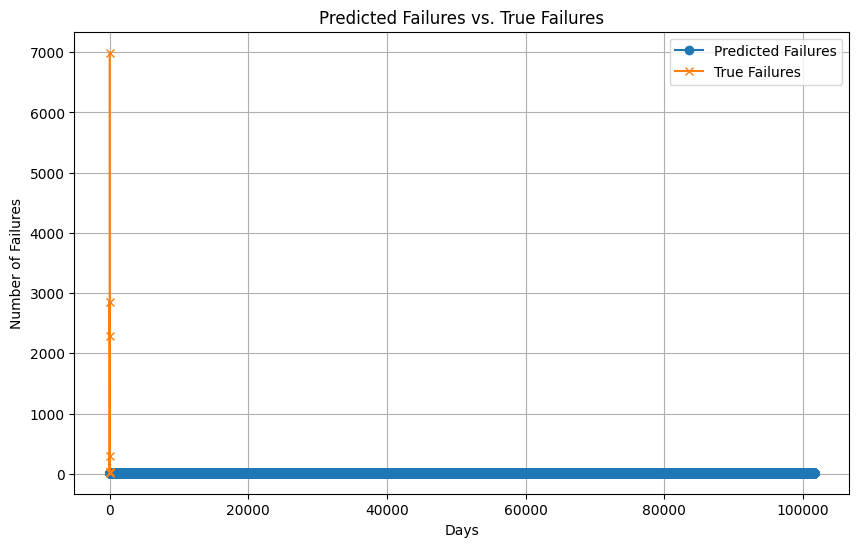

In [ ]:
input_data = X_test_day[2]  # Can be any valid starting point

# Make predictions for the specified number of days
predicted_failures = predict_future_failures(lstm_model_day, input_data, sequence_length, prediction_steps)

# Denormalize the predicted failures 
predicted_failures_denormalized = predicted_failures * (lstm_data_day['target'].max() - lstm_data_day['target'].min()) + lstm_data_day['target'].min()

# Get the true failures for the specified number of days
true_failures = y_test_day[2:2 + prediction_steps]  # Adjust the range as needed

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_denormalized, label='Predicted Failures', marker='o')
plt.plot(true_failures, label='True Failures', marker='x')
plt.xlabel('Days')
plt.ylabel('Number of Failures')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.grid(True)
plt.show()
